In [234]:
from datetime import datetime, timezone, timedelta
import requests
import json
import numpy as np
import pandas as pd
import urllib3
import calendar
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import matplotlib.pyplot as plt

crw = 'https://tools.izmiran.ru/w/api'

def obtain_omni(dt_from, dt_to, query):
	tfr, tto = [int(d.replace(tzinfo=timezone.utc).timestamp()) for d in (dt_from, dt_to)]
	uri = f'https://tools.izmiran.ru/w/api/omni/?from={tfr}&to={tto}&query={",".join(query)}'
	res = requests.get(uri, verify=False, timeout=10000)
	if res.status_code != 200:
		raise Exception(f'request failed: {res.status_code}')
	body = json.loads(res.text)
	data = np.array(body.get('rows'))
	times = [datetime.fromtimestamp(d, timezone.utc) for d in data[:,0]]
	return np.column_stack((times, data[:,1:]))

series = ['ap_index', 'kp_index']
months = [3, 11]
years = list(range(1980, 2025))

parts = []
for month in months:
	for year in years:
		dt_from = datetime(year, month, 1)
		dt_to = datetime(year, month+1, 1) - timedelta(minutes=1)
		res = obtain_omni(dt_from, dt_to, series)
		res[:,2] /= 10 # divide kp index
		parts.append(res)

data = np.vstack(parts)

df = pd.DataFrame(data, index=data[:,0], columns=['time', 'ap', 'kp'])
for s in ['ap', 'kp']:
	df[s] = pd.to_numeric(df[s])
df.describe()

,ap,kp
count,65880.000000,65880.000000
mean,13.026366,2.128629
std,19.648860,1.480242
min,0.000000,0.000000
25%,4.000000,1.000000
50%,7.000000,2.000000
75%,15.000000,3.000000
max,400.000000,9.000000


In [235]:
monthly = df.groupby([df.index.year, df.index.month]).agg({'time': 'first','ap': 'mean','kp': 'mean'})
daily = df.groupby([df.index.year, df.index.month, df.index.day]).agg({'time': 'first','ap': 'mean','kp': 'mean'})

# export 

which = daily
month = 3

data = which[which['time'].dt.month == month].round(4)
print(data.to_csv(index=False))

time,ap,kp
1980-03-01 00:00:00+00:00,3.375,0.775
1980-03-02 00:00:00+00:00,2.625,0.5375
1980-03-03 00:00:00+00:00,4.625,1.0875
1980-03-04 00:00:00+00:00,4.875,1.2375
1980-03-05 00:00:00+00:00,6.625,1.6
1980-03-06 00:00:00+00:00,8.625,2.2
1980-03-07 00:00:00+00:00,6.625,1.7875
1980-03-08 00:00:00+00:00,6.375,1.6875
1980-03-09 00:00:00+00:00,7.25,1.825
1980-03-10 00:00:00+00:00,4.25,1.0875
1980-03-11 00:00:00+00:00,4.5,1.0875
1980-03-12 00:00:00+00:00,1.25,0.2875
1980-03-13 00:00:00+00:00,6.625,1.625
1980-03-14 00:00:00+00:00,4.875,1.25
1980-03-15 00:00:00+00:00,1.625,0.3125
1980-03-16 00:00:00+00:00,4.5,1.1875
1980-03-17 00:00:00+00:00,5.125,1.325
1980-03-18 00:00:00+00:00,3.625,0.8875
1980-03-19 00:00:00+00:00,9.75,2.0
1980-03-20 00:00:00+00:00,4.5,1.1625
1980-03-21 00:00:00+00:00,17.75,3.2125
1980-03-22 00:00:00+00:00,16.5,3.0375
1980-03-23 00:00:00+00:00,5.5,1.2875
1980-03-24 00:00:00+00:00,4.25,1.0875
1980-03-25 00:00:00+00:00,6.125,1.3375
1980-03-26 00:00:00+00:00,29.75,3.9625
1980

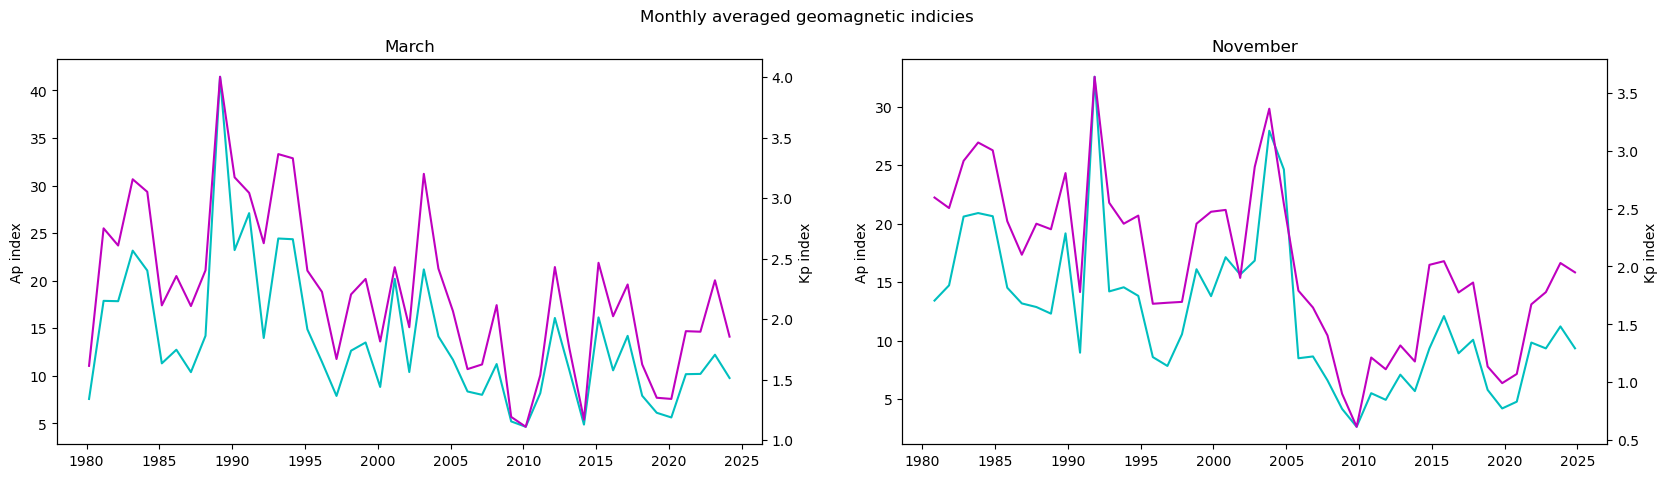

In [236]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for i, month in enumerate(months):
	data = monthly[monthly['time'].dt.month == month]
	x, y = data['time'], data['ap']
	x2, y2 = data['time'], data['kp']

	ax = axes[i]
	axr = ax.twinx()

	ax.set_title(f'{calendar.month_name[month]}')
	ax.set_ylabel('Ap index')
	axr.set_ylabel('Kp index')

	ax.plot(x, y, c='c')
	axr.plot(x2, y2, c='m')

fig.suptitle(f'Monthly averaged geomagnetic indicies')
plt.show()

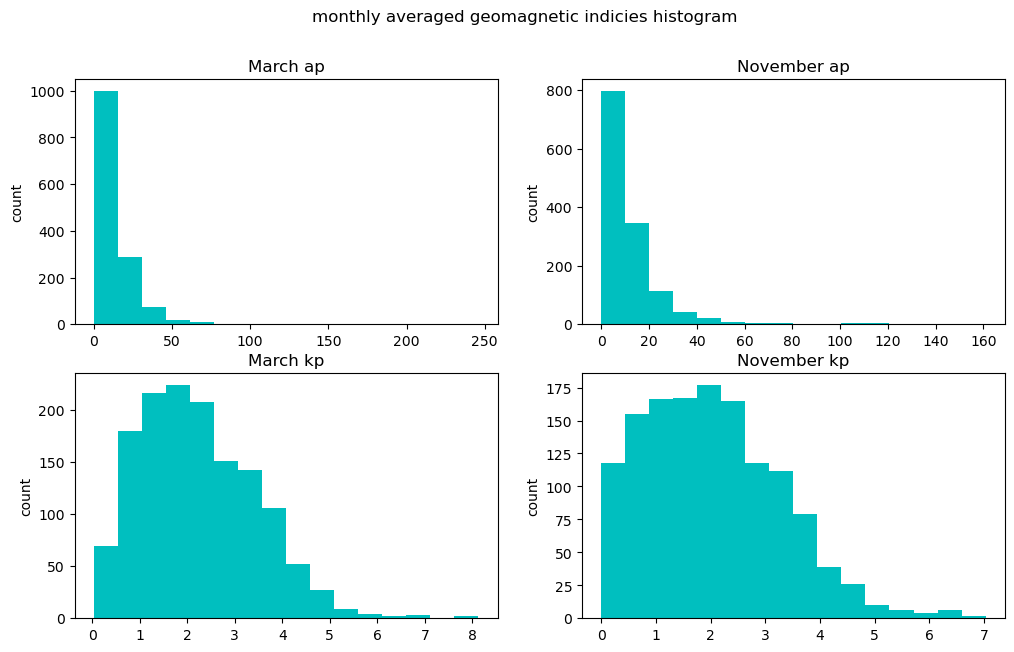

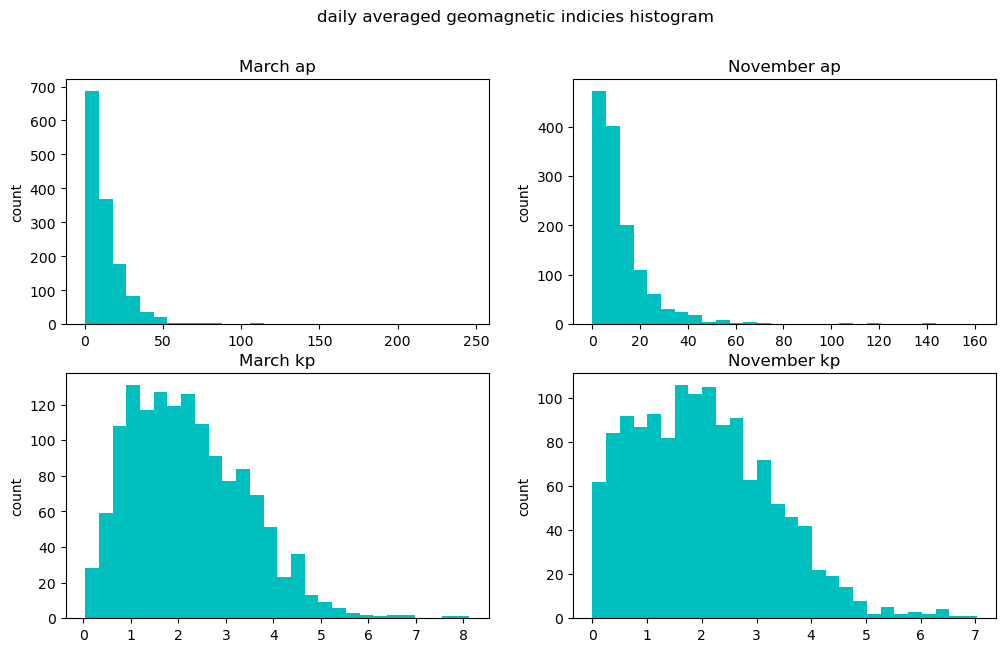

In [237]:

for averaging, averaged, bins in [['monthly', monthly, 16], ['daily', daily, 28]]:
	fig, axes = plt.subplots(2, 2, figsize=(12, 7))

	for i, month in enumerate(months):
		for si, series in enumerate(['ap', 'kp']):
			data = daily[daily['time'].dt.month == month]
			y = data[series]
			ax = axes[si][i]

			ax.set_title(f'{calendar.month_name[month]} {series}')
			ax.set_ylabel('count')

			ax.hist(y, bins=bins, color='c')

	fig.suptitle(f'{averaging} averaged geomagnetic indicies histogram')
	plt.show()

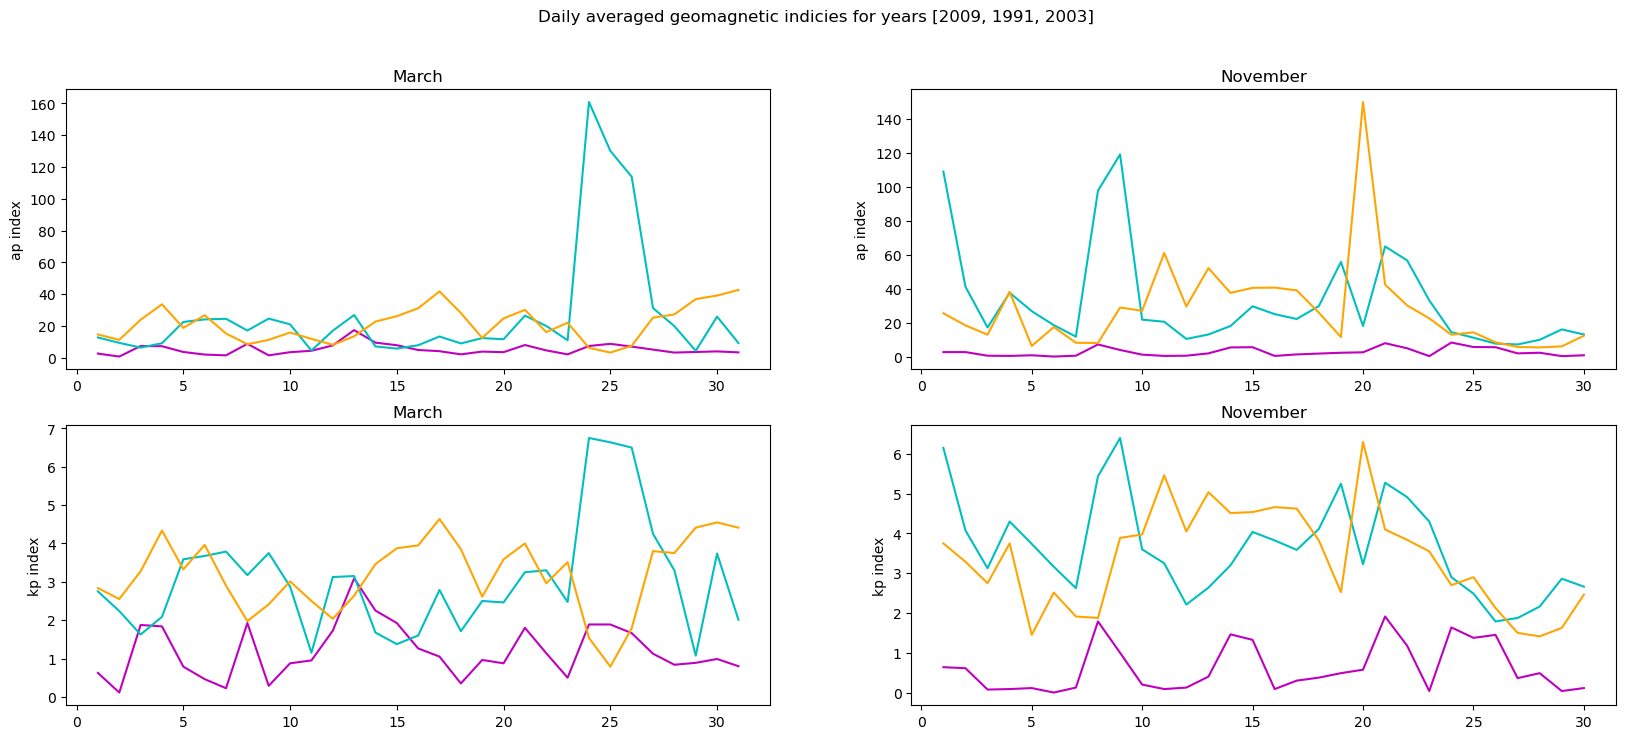

In [238]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
yrs = [2009, 1991, 2003]

for i, month in enumerate(months):
	for si, series in enumerate(['ap', 'kp']):
		ax = axes[si][i]
		ax.set_title(f'{calendar.month_name[month]}')
		ax.set_ylabel(f'{series} index')

		for yi, y in enumerate(yrs):
			data = daily.loc[(y, month)]
			x, y = data['time'], data[series]
			x = x.dt.day
			ax.plot(x, y, c=['m','c','orange'][yi])

fig.suptitle(f'Daily averaged geomagnetic indicies for years {yrs}')
plt.show()